<hr style="border-top-width:4px; border-top-color: #00df;">

# Final Project of MAPD-B: Analysis of Covid-19 papers

#### Group Members: 
Fateme Baghaei Saryazdi &nbsp; 2088827 <br>
Qiqi Zhang &nbsp; 2072838 <br>
Poornima Wickramasinghe &nbsp; 2088370

<hr style="border-top-width:4px; border-top-color: #00df;">

# Introduction
This distributed computing project will be focused on the analysis of a number of papers
about COVID-19, SARS-CoV-2, and related coronaviruses. The dataset is a sub-sample
taken from the original dataset that is composed of 75000 (and still increasing) papers.
This dataset is a part of real-world research on COVID-19 named COVID-19 Open Re-search Dataset Challenge (CORD-19). The research and related challenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge .
For this project we used 1000 papers from the third version of the dataset.

In [1]:
import os
import json
import time
import csv
from dask import delayed
import dask.bag as db
import dask.dataframe as dd
import functools
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
from collections import Counter
from operator import add
from operator import itemgetter
import matplotlib.pyplot as plt
from operator import itemgetter
import string
import seaborn as sns
import dask
import ast
from dask import compute
import io
from dask.distributed import LocalCluster
import dask.array as da
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import dask.array as da
import re
import pprint
import pycountry

* There are three vitual machines: 

In [2]:
from dask.distributed import Client, SSHCluster
scheduler = '10.67.22.110'
worker1 = '10.67.22.156'
worker2 = '10.67.22.62'

* Define the Client with SSHCluster:

In [3]:
cluster = SSHCluster([scheduler, worker1, worker2],
                    scheduler_options={"port": 0, "dashboard_address": ":8888"}
                    ,connect_options={"known_hosts": None})
client = Client(cluster)

2024-01-28 15:55:51,925 - distributed.deploy.ssh - INFO - 2024-01-28 15:55:51,925 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-01-28 15:55:51,928 - distributed.deploy.ssh - INFO - /home/wickramasinghemudiyanselage/miniconda3/envs/myenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8888 is already in use.
2024-01-28 15:55:51,928 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2024-01-28 15:55:51,929 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 38657 instead
2024-01-28 15:55:51,929 - distributed.deploy.ssh - INFO - warnings.warn(
2024-01-28 15:55:51,954 - distributed.deploy.ssh - INFO - 2024-01-28 15:55:51,954 - distributed.scheduler - INFO - State start
2024-01-28 15:55:51,958 - distributed.deploy.ssh - INFO - 2024-01-28 15:55:51,957 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22

In [4]:
client

<Client: 'tcp://10.67.22.110:37211' processes=2 threads=8, memory=15.50 GiB>

This is the function for loading the json file

In [5]:
def load_json_data(filename):
    
    with open(os.path.join(folder_path, filename), 'r') as file:
        json_data = json.load(file)
        
    return json_data

## Task 1: Word Counter Algorithm Distributed Algorithm:

First of all, we implement the following two distributed algorithm to count the occur-
rences of all the words inside a list of documents. In NLP (Natural Language Processing)
a document is a body of text, in this case, each paper is a document. The algorithms are
map phase and reduce phase.

In [6]:
folder_path = '/home/wickramasinghemudiyanselage/comm_use_subset/comm_use_subset/'
file_list = os.listdir(folder_path)

# Create a Dask Bag to store the imported data
bag = db.from_sequence(file_list).map(load_json_data)

In [7]:
# Download NLTK stopwords
#nltk.download('stopwords')


def mk_str(paper):
    body_text = paper['body_text']
    text = ''.join([x['text'] for x in body_text])
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    
    return words


In [8]:

stop_words = set(stopwords.words('english'))
omit_words = ['et', 'al', 'also', 'may', 'using', 'used', 'de', 'however', 'fig']

def sanitize_words(words):
    # Lowercase every word
    words = [word.lower() for word in words]
    
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    words = [word.translate(translator) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and word not in omit_words]
    
    # Remove numbers
    words = [word for word in words if not word.isdigit()]

    # Remove empty strings
    words = [word for word in words if word]

    return words

# Map Phase:
For each document Di, we produce the set of intermediate pairs (w, cp(w)),
one for each word w ∈ Di, where cp(w) is the number of occurrences of w in Di.

In [9]:
def map_phase(document):
    # Sanitize the document
    words = sanitize_words(document)

    # Count occurrences of each word
    word_counts = Counter(words)

    return list(word_counts.items())

In [10]:
# Map Phase
mapped_data = bag.map(mk_str).map(sanitize_words).map(map_phase)

In [11]:
# Flatten the bag since you have a list of word count pairs for each document
flat_mapped_data = mapped_data.flatten()

# Reduce Phase:
For each word w, gather all the previous pairs (w, cp(w)) and return
the final pair (w, c(w)) where c(w) is the number of occurrences of w for all the documents.

In [12]:
def reduce_phase(intermediate_pairs):
    # Aggregate counts for each unique word using a dictionary
    word_count_dict = {}
    for word, count in intermediate_pairs:
        if word in word_count_dict:
            word_count_dict[word] += count
        else:
            word_count_dict[word] = count

    # Convert the dictionary items to a list of (word, final_count) pairs
    final_pairs = list(word_count_dict.items())

    return final_pairs

In [13]:
# Reduce Phase
result = flat_mapped_data.foldby(lambda x: x[0], lambda acc, x: acc + x[1], initial=0, combine=add)

# Convert to a Dask DataFrame
df = result.to_dataframe(columns=['Word', 'Count']).compute()

# Display the resulting DataFrame
#print(df)


In [14]:
# Sort the DataFrame in descending order based on the "Count" column
df = df.sort_values('Count', ascending=False)
df.head(10)

,Word,Count
340,cells,168662
42,virus,115231
115,infection,99399
151,viral,92367
85,protein,79922
527,study,76571
78,cell,73642
1524,figure,71927
290,data,71696
684,viruses,57488


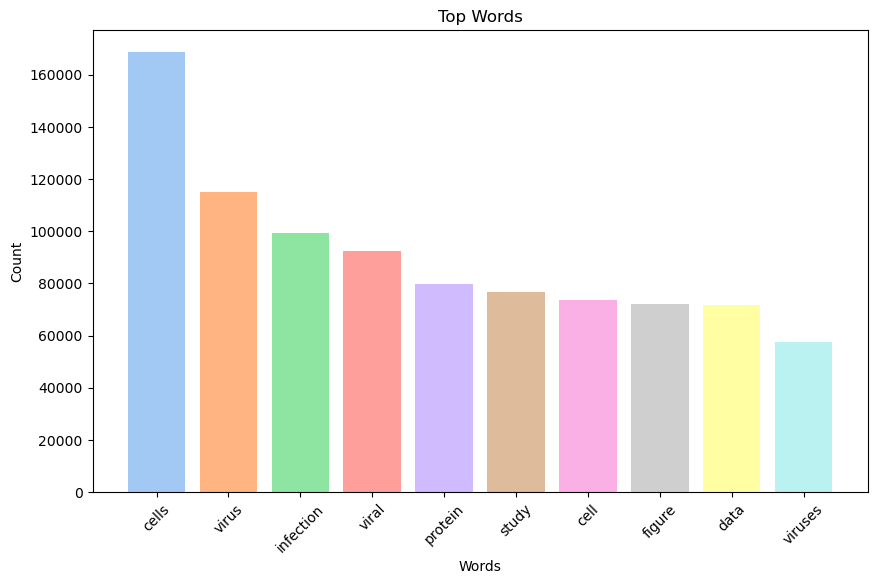

In [15]:

# Extract top N words (let's say top 10 for example)
top_n = 10
top_words = df.head(top_n)

# Set the Seaborn color palette
sns.set_palette('pastel')

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_words['Word'], top_words['Count'], color=sns.color_palette())
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top Words')
plt.xticks(rotation=45)
plt.show()

## Task 2: The worst and best represented countries and universities in the research

In this part, we take the documents and convert them into a usable DataFrame data structure to figure out the countries that are most and less active in the research. To do this we use the country of the authors. And afterwards, we do the same for the universities.

In [16]:
folder_path = '/home/wickramasinghemudiyanselage/comm_use_subset/comm_use_subset/'
file_list = os.listdir(folder_path)

In [17]:
translator = str.maketrans('', '', string.punctuation)
def extract_countries_from_paper(paper):
    extracted_countries = []

    if 'authors' in paper.get('metadata', {}):
        authors = paper['metadata']['authors']

        if authors:
            for author_info in authors:
                affiliation = author_info.get('affiliation', {})
                location = affiliation.get('location', {})
                country = location.get('country', '')

                if country:
                    extracted_countries.append(country)
                else:
                    extracted_countries.append('NN')
        else:
            extracted_countries.append('NAuthor')
    else:
        extracted_countries.append('NN')

    return extracted_countries


In [18]:
def replace_elements_in_list(original_list, elements_to_replace, replacement_elements):
    """
    Replace elements in a list based on a mapping.

    Args:
        original_list (list): The list to modify.
        elements_to_replace (list): List of elements to replace.
        replacement_elements (list): List of replacement elements.

    Returns:
        list: Modified list with replaced elements.
    """
    element_mapping = {old_elem: new_elem for old_elem, new_elem in zip(elements_to_replace, replacement_elements)}
    modified_list = [element_mapping.get(elem, elem) for elem in original_list]
    return modified_list


In [19]:
def preprocess_and_filter_words(input_text):
    """
    Preprocess a text by cleaning and filtering its content.

    Args:
        input_text (str): Input text.

    Returns:
        list: List of filtered words.
    """
    # Remove non-alphabetic characters and clean the text
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', input_text)

    # Convert to lowercase, strip, and split into words
    words = list(set(cleaned_text.lower().strip().split()))


    # Exclude common English stopwords
    stop_words = set(stopwords.words('english'))

    # Filter out stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return filtered_words


In [20]:
def standardize_country_names(original_country_list, preprocessed_flattened_list):
    """
    Standardize country names based on predefined mapping lists.

    Args:
        original_country_list (list): List of original country names to process.
        preprocessed_flattened_list (list): Flattened list of preprocessed country names.

    Returns:
        list: List of standardized country names.
    """
    words_to_change = ['kingdom', 'america', 'zealand', 'arabia', 'us']
    replacement_words = ['uk', 'usa', 'newzealand', 'saudiarabia', 'usa']

    processed_nested_list = [preprocess_and_filter_words(name) for name in original_country_list]
    processed_flat_list = [item for sublist in processed_nested_list for item in sublist]
    selected_processed_list = [item for item in processed_flat_list if item in preprocessed_flattened_list]
    standardized_country_list = replace_elements_in_list(selected_processed_list, words_to_change, replacement_words)

    return standardized_country_list


In [21]:
def remove_values(original_list, values_to_remove):
    """
    Remove specified values from a list.

    Args:
        original_list (list): List to modify.
        values_to_remove (list): List of values to remove.

    Returns:
        list: Modified list with specified values removed.
    """
    filtered_list = [element for element in original_list if element not in values_to_remove]
    return filtered_list


In [22]:
countries = list(pycountry.countries)
clist2 = [country.name for country in countries]
nested_list_country2 = [preprocess_and_filter_words(word) for word in clist2]
flattened_list2 = list([item for sublist in nested_list_country2 for item in sublist])
flattened_list2.extend(['usa' , 'uk' , 'nn' , 'nauthor'])
flattened_list2 = remove_values(flattened_list2 , ['united' , 'states' , 'new' , 'peoples' , 'islamic' , 'republic' , 'saudi'])

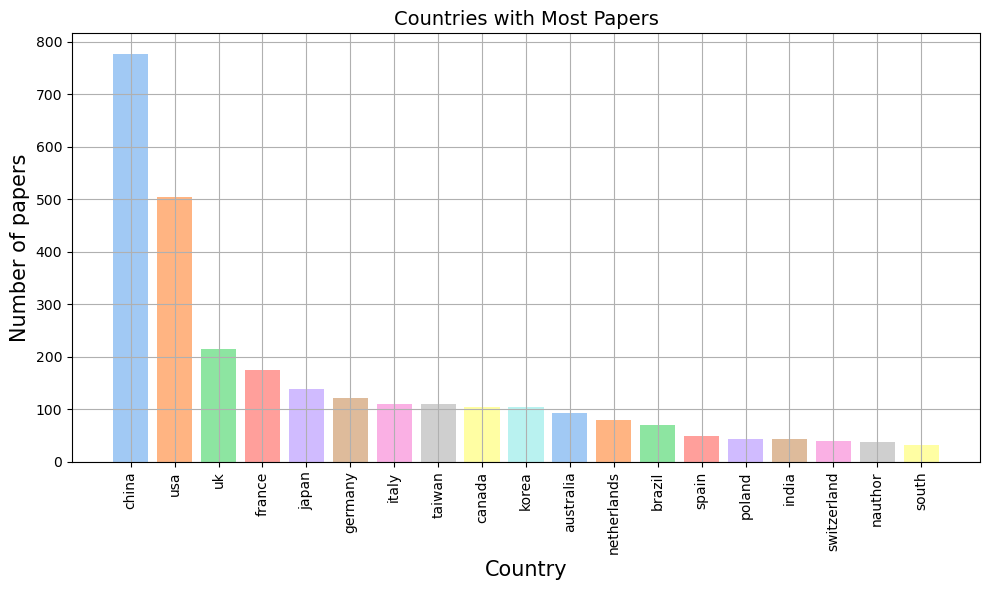

In [23]:
n_paper = 1000
n_repartition = 60
amount = 20

df_country = (
    db.from_sequence(file_list[0:n_paper] , partition_size = n_repartition)
    .map(load_json_data)
    .map(extract_countries_from_paper)
    .map(lambda x: standardize_country_names(x , flattened_list2))
    .flatten()
    .frequencies()
    .to_dataframe(columns=['Country', 'Count'])
    .nlargest(n=amount, columns='Count')
)

head = df_country.compute()

# Set the color palette
colors = sns.color_palette('pastel')

plt.figure(figsize=(10, 6))
plt.bar(head['Country'][1:], head['Count'][1:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('Country', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Countries with Most Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

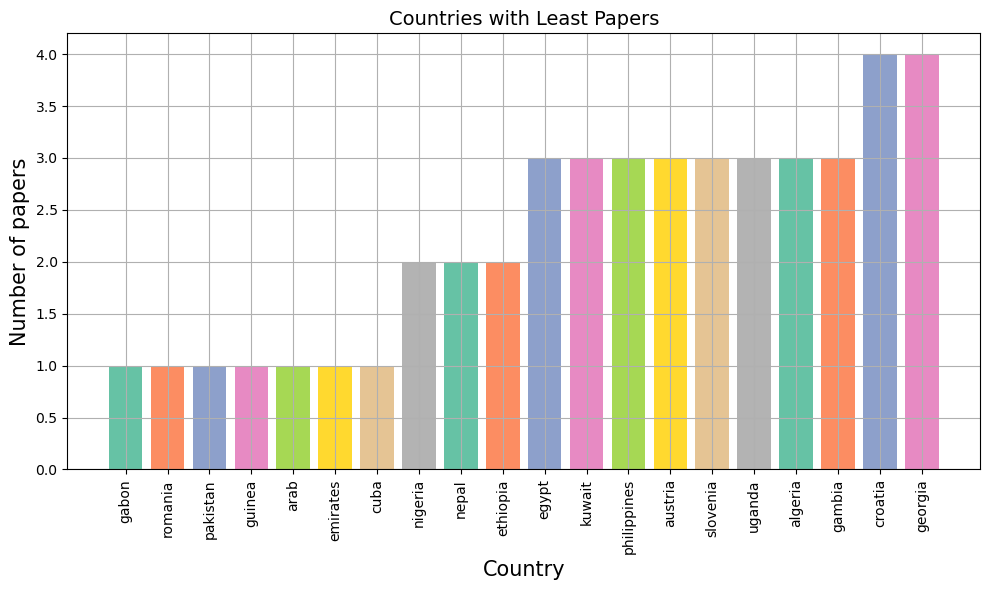

In [24]:
df_country = (
    db.from_sequence(file_list[0:n_paper], partition_size = n_repartition)
    .map(load_json_data)
    .map(extract_countries_from_paper)
    .map(lambda x: standardize_country_names(x , flattened_list2))
    .flatten()
    .frequencies()
    .to_dataframe(columns=['Country', 'Count'])
    .nsmallest(n=amount, columns='Count')
)

tail = df_country.compute()


# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 6))
plt.bar(tail['Country'], tail['Count'], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('Country', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Countries with Least Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
def extract_universities_from_paper(paper):
    """
    Extract universities mentioned in a paper's metadata.

    Args:
        paper (dict): Paper content as a dictionary.

    Returns:
        list: List of extracted universities.
    """
    universities = []

    if 'authors' in paper.get('metadata', {}):
        authors = paper['metadata']['authors']

        if authors:
            for author_info in authors:
                affiliation = author_info.get('affiliation', {})
                institution = affiliation.get('institution', '')

                if institution:
                    universities.append(institution)
                else:
                    universities.append('NN')
        else:
            universities.append('NA')

    return universities


In [26]:
df_uni = (
    db.from_sequence(file_list[0:n_paper], partition_size = 75)
    .map(load_json_data)
    .map(extract_universities_from_paper)
    .flatten()
    .frequencies()
    .to_dataframe(columns=['University', 'Count'])
    .nlargest(n=amount, columns='Count')
)

head = df_uni.compute()

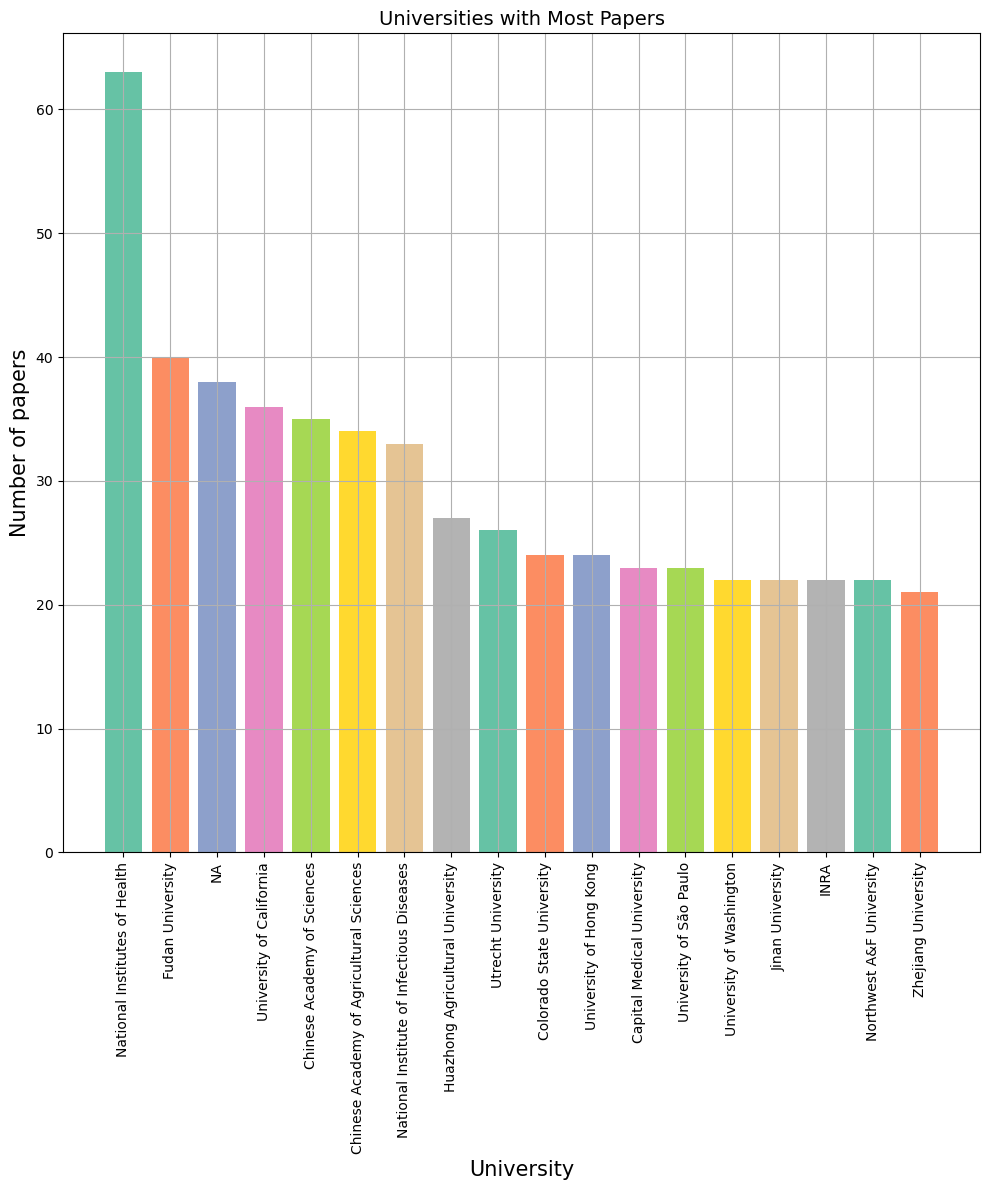

In [27]:
# Set the color palette
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 12))
plt.bar(head['University'][2:], head['Count'][2:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('University', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Universities with Most Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

In [28]:
df_country = (
    db.from_sequence(file_list[0:n_paper], partition_size = 75)
    .map(load_json_data)
    .map(extract_universities_from_paper)
    .flatten()
    .frequencies()
    .to_dataframe(columns=['University', 'Count'])
    .nsmallest(n=amount, columns='Count')
)

tail = df_country.compute()


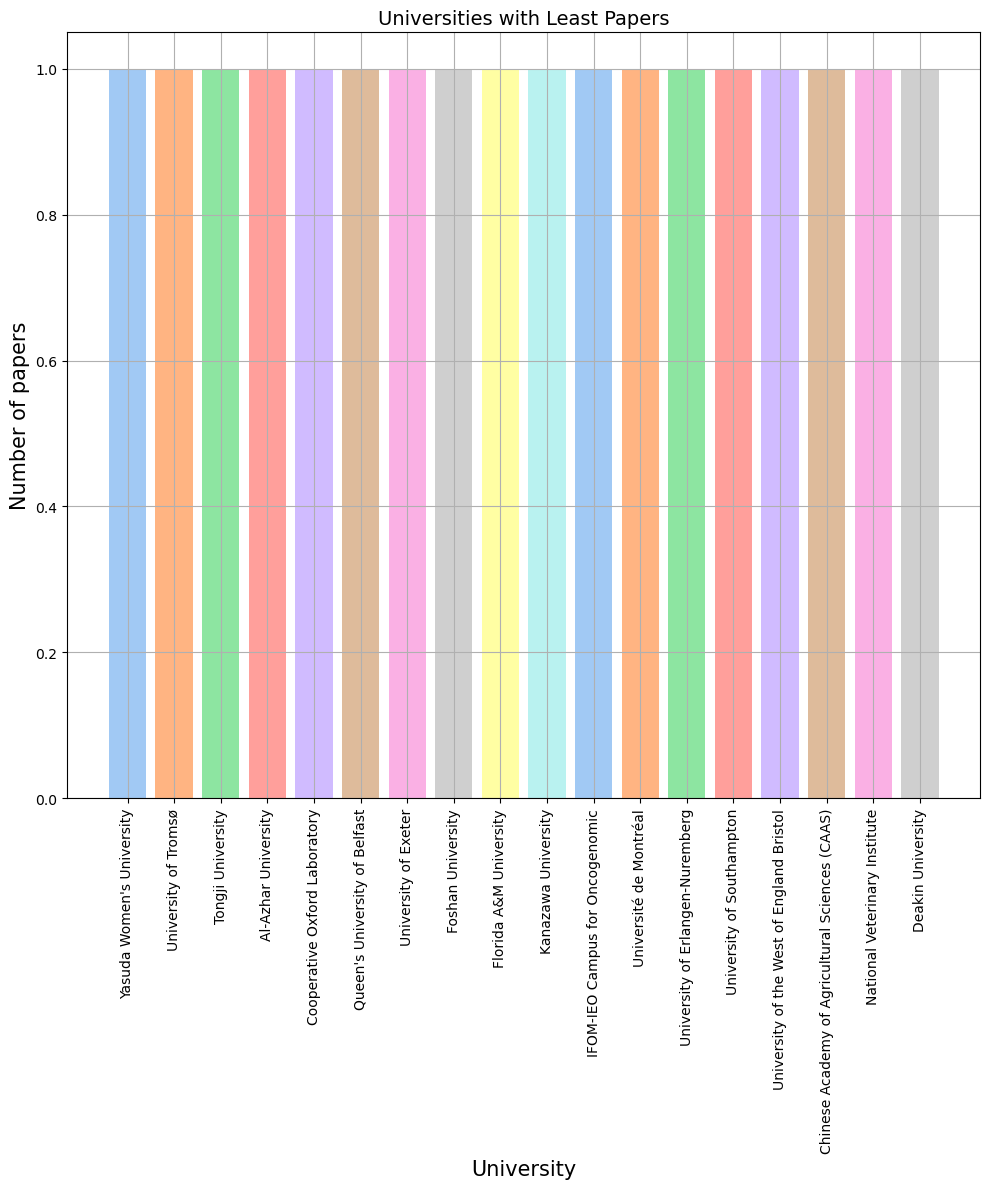

In [29]:
# Set the color palette
colors = sns.color_palette('pastel')

plt.figure(figsize=(10, 12))
plt.bar(tail['University'][2:], tail['Count'][2:], color=colors)

# Adjusting font size for all elements
fs = 15
plt.xlabel('University', fontsize=fs)
plt.ylabel('Number of papers', fontsize=fs)
plt.title('Universities with Least Papers', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Adding gridlines
plt.grid(True)

# Adjusting spacing
plt.tight_layout()

# Display the plot
plt.show()

In [30]:
client.close()
cluster.close()